In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import itertools
from IPython import display
import rldurham as rld
from rldurham import plot_frozenlake as plot

In [2]:
name = 'FrozenLake-v1'
env = rld.make(name, is_slippery=False)                 # 4x4
env = rld.make(name, map_name="8x8", is_slippery=False) # 8x8
# env = rld.make(name, desc=["SFHH",
#                            "HFFH",
#                            "HHFF",
#                            "HHHG",], is_slippery=False) # custom
rld.seed_everything(42, env)
# LEFT, DOWN, RIGHT, UP = 0, 1, 2, 3

Seed set to 42


(42, 0, {'prob': 1})

In [3]:
class QPolicy:
    def __init__(self, Q, epsilon, values=False):
        self.Q = Q
        self.epsilon = epsilon
        self.values = values
    def sample(self, state):
        if np.random.rand() > self.epsilon:
            best_actions = np.argwhere(self.Q[state]==np.max(self.Q[state])).flatten()
            return np.random.choice(best_actions)
        else:
            return env.action_space.sample()
    def __getitem__(self, item):
        state, action = item
        if self.values:
            return self.Q[state, action] / (self.Q[state].sum() + 1e-10)
        else:
            best_actions = np.argwhere(self.Q[state]==np.max(self.Q[state])).flatten()
            p = int(action in best_actions) / len(best_actions)
            return (1 - self.epsilon) * p + self.epsilon / len(self.Q[state])
class HardCodedPolicy:
    def __init__(self, state_action_map):
        self.state_action_map = state_action_map
    def sample(self, state):
        if state in self.state_action_map:
            return np.random.choice(self.state_action_map[state])
        else:
            return np.random.choice(4)
    def __getitem__(self, item):
        state, action = item
        if state in self.state_action_map:
            if action in self.state_action_map[state]:
                return 1 / len(self.state_action_map[state])
            else:
                return 0
        else:
            return 1 / 4

In [4]:
# (using global variables in functions)
def update_plot(mod):
    reward_list[experiment_id].append(reward_sum)
    aoc[experiment_id] += reward_sum
    test_reward_list[experiment_id].append(test_reward_sum)
    test_aoc[experiment_id] += test_reward_sum
    if episode % mod == 0:
        plot_data[experiment_id].append([episode,
                                         np.array(reward_list[experiment_id]).mean(),
                                         np.array(test_reward_list[experiment_id]).mean()])
        reward_list[experiment_id] = []
        test_reward_list[experiment_id] = []
        for i in range(len(plot_data)):
            # color=next(plt.gca()._get_lines.prop_cycler)['color']
            lines = plt.plot([x[0] for x in plot_data[i]],
                     [x[1] for x in plot_data[i]],
                     '-', 
                     # color=color,
                     label=f"{plot_labels[i]}, AOC: {aoc[i]}|{test_aoc[i]}")
            color = lines[0].get_color()
            plt.plot([x[0] for x in plot_data[i]],
                     [x[2] for x in plot_data[i]], '--', 
                     color=color
                    )
        plt.xlabel('Episode number')
        plt.ylabel('Episode reward')
        plt.legend()
        display.clear_output(wait=True)
        plt.show()
        
def next_experiment():
    reward_list.append([])
    aoc.append(0)
    test_reward_list.append([])
    test_aoc.append(0)
    plot_data.append([])
    return experiment_id + 1

In [5]:
reward_list = [[]]
aoc = [0]
test_reward_list = [[]]
test_aoc = [0]
plot_data = [[]]
plot_labels = []
experiment_id = 0

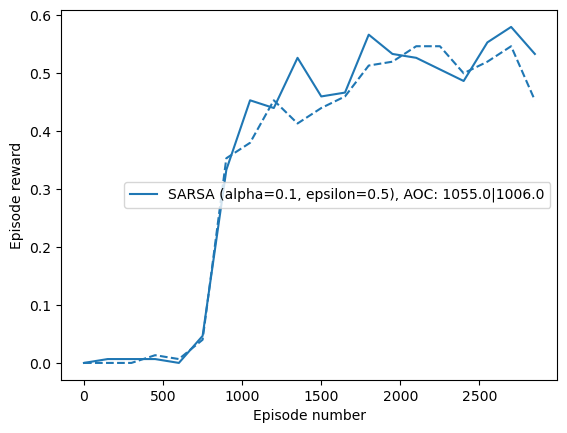

Sampling policy and values


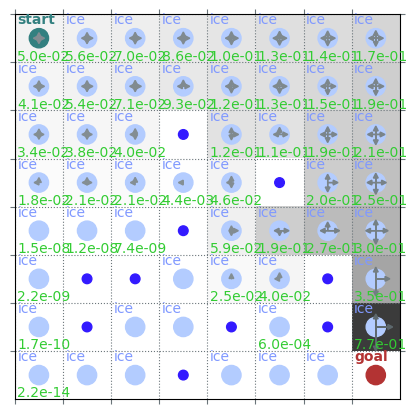

Learned policy and optimal/max values


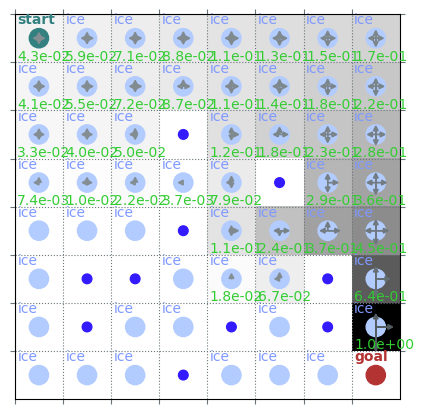

In [6]:
# parameters
num_episodes = 3000
alpha = 0.1
gamma = 0.9
epsilon = 0.5

Q = np.random.uniform(0, 1e-5, [env.observation_space.n, env.action_space.n]) # noisy
Q = np.zeros([env.observation_space.n, env.action_space.n])                   # neutral
V = np.zeros([env.observation_space.n])

# # policies
sample_policy = QPolicy(Q, epsilon)
learned_policy = sample_policy
plot_labels.append(f"SARSA (alpha={alpha}, epsilon={epsilon})")

# policies
# sample_policy = QPolicy(Q, epsilon)
# td_epsilon = 0.1
# learned_policy = QPolicy(Q, td_epsilon)
# plot_labels.append(f"Q-Learning (alpha={alpha}, epsilon={epsilon}|{td_epsilon})")

for episode in range(num_episodes):
    state, _ = env.reset()
    reward_sum = 0
    # learning a policy
    for t in itertools.count():
        action = sample_policy.sample(state)
        next_state, reward, term, trun, _ = env.step(action)
        done = term or trun
        next_action = learned_policy.sample(next_state)
        # TD(0) targets
        v_target = reward + gamma * V[next_state]
        q_target = reward + gamma * Q[next_state, next_action]
        # updates
        s, a = state, action
        V[s] += alpha * (v_target - V[s])
        Q[s, a] += alpha * (q_target - Q[s, a])

        reward_sum += reward
        if done:
            break
        state = next_state

    # testing the learned policy
    state, _ = env.reset()
    test_reward_sum = 0
    while True:
        action = learned_policy.sample(state)
        next_state, reward, term, trun, _ = env.step(action)
        done = term or trun
        test_reward_sum += reward
        state = next_state
        if done:
            break

    update_plot(int(np.ceil(num_episodes / 20)))

env.close()
experiment_id = next_experiment()
print("Sampling policy and values")
plot(env, v=V, policy=sample_policy.Q, draw_vals=True)
print("Learned policy and optimal/max values")
plot(env, v=Q.max(axis=1), policy=learned_policy.Q, draw_vals=True)

In [7]:
reward_list = [[]]
aoc = [0]
test_reward_list = [[]]
test_aoc = [0]
plot_data = [[]]
plot_labels = []
experiment_id = 0

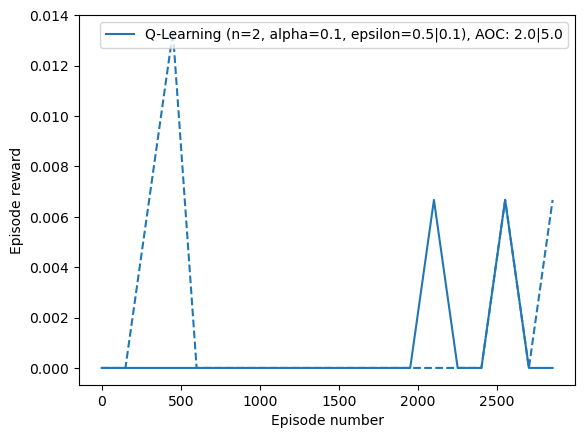

Sampling policy and values


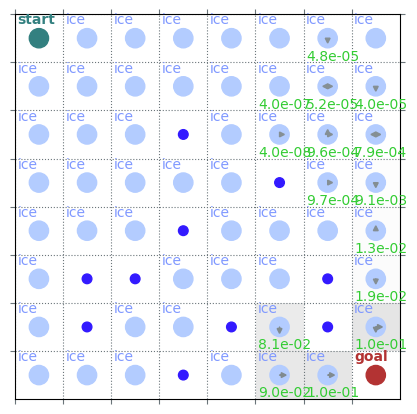

Learned policy and optimal/max values


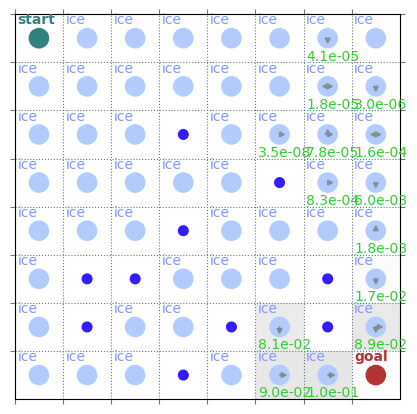

In [8]:
# parameters
num_episodes = 3000
alpha = 0.1
gamma = 0.9
epsilon = 0.5
n = 2

Q = np.random.uniform(0, 1e-5, [env.observation_space.n, env.action_space.n]) # noisy
Q = np.zeros([env.observation_space.n, env.action_space.n])                   # neutral
V = np.zeros([env.observation_space.n])

# # policies
# sample_policy = QPolicy(Q, epsilon)
# learned_policy = sample_policy
# plot_labels.append(f"SARSA (n={n}, alpha={alpha}, epsilon={epsilon})")

# policies
sample_policy = QPolicy(Q, epsilon)
td_epsilon = 0.1
learned_policy = QPolicy(Q, td_epsilon)
plot_labels.append(f"Q-Learning (n={n}, alpha={alpha}, epsilon={epsilon}|{td_epsilon})")

for episode in range(num_episodes):
    state, _ = env.reset()
    reward_sum = 0
    trace = np.zeros((n + 1, 4), dtype=int)
    done_n = 0
    # learning a policy
    for t in itertools.count():
        action = sample_policy.sample(state)
        next_state, reward, term, trun, _ = env.step(action)
        done = term or trun
        next_action = learned_policy.sample(next_state)
        trace[-1] = (state, action, reward, next_action)
        if t > n:
            # n-step targets
            n_step_return = sum(gamma ** i * r for i, (_, _, r, _) in enumerate(trace))
            v_target = n_step_return + gamma ** (n + 1) * V[next_state]
            q_target = n_step_return + gamma ** (n + 1) * Q[next_state, next_action]

            # # updates
            # s, a, _, _ = trace[0]
            # V[s] += alpha * (v_target - V[s])
            # Q[s, a] += alpha * (q_target - Q[s, a])

            # importance sampling factor
            rho = np.prod([learned_policy[s, a] / sample_policy[s, a] for s, a, _, _ in trace])
            # updates
            s, a, _, _ = trace[0]
            V[s] += alpha * rho * (v_target - V[s])
            Q[s, a] += alpha * rho * (q_target - Q[s, a])

        reward_sum += reward
        done_n += done
        if done_n > n:
            break
        state = next_state
        trace = np.roll(trace, shift=-1, axis=0)

    # testing the learned policy
    state, _ = env.reset()
    test_reward_sum = 0
    while True:
        action = learned_policy.sample(state)
        next_state, reward, term, trun, _ = env.step(action)
        done = term or trun
        test_reward_sum += reward
        state = next_state
        if done:
            break

    update_plot(int(np.ceil(num_episodes / 20)))

env.close()
experiment_id = next_experiment()
print("Sampling policy and values")
plot(env, v=V, policy=sample_policy.Q, draw_vals=True)
print("Learned policy and optimal/max values")
plot(env, v=Q.max(axis=1), policy=learned_policy.Q, draw_vals=True)